In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import solve_ivp


In [57]:
# T_theta = 125 # ms, theta osicillation period
A_STDP = 0.03; s_STDP = 4 # parameters for STDP
omega = lambda dx: A_STDP * np.exp(s_STDP*np.cos(dx)) * np.sin(dx) # gabor as STDP rule
domega = lambda dx: A_STDP * np.exp(s_STDP*np.cos(dx)) * (np.cos(dx) - s_STDP*np.sin(dx)**2) # derivative of STDP in respect to xi (postsynaptic)
# plot STDP and PCF
# u = np.arange(-np.pi,np.pi,np.pi/120)
# plt.plot(u,omega(u))
# plt.plot(u,domega(u))
# plt.plot(u,domega(u)*omega(u))

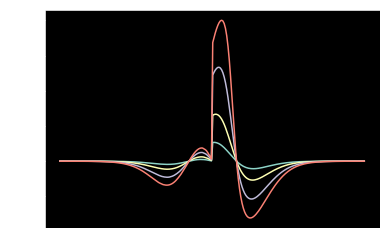

In [58]:
du=np.pi/120 
u = np.arange(-np.pi,np.pi,du) # a bunch of testing phase 
uu=u.copy();uu[u<=0]+=2*np.pi # wrap into range (0,2pi]
PRC = np.zeros_like(u)
k_prior = 0.6 # confidence of prior (x=0)
for w in [0.01,0.025, 0.05, 0.075]:
        for i,xj in enumerate(uu):
                x=0 # postsynaptic start from 0 phase
                t=xj # phase response integrate from presynaptic fire
                dt = 0.002*np.pi
                while (t+dt-x)<2*np.pi: # fire when x == t mod 2pi
                        dx = dt*(-k_prior*np.sin(x)+w*domega(x-xj))
                        x+=dx
                        t+=dt
                PRC[i] = x
        plt.plot(u,PRC)

In [59]:
def mainode(t,x):
    # global variables:
    # N is number of neurons
    # Wij is the synpatic efficancy from neuron j to i
    # sigma2_w is the variance of W
    # x_tilde is the recall cue
    # k_{prior,noise} is the concentration of prior and 
    # cue distribution
    # phase, dynamically updated at each event
    H = np.zeros((N,N))
    for j in range(N):
        dxij = x-x[j] # phase difference between neurons
        H[:,j] = W[:,j] * domega(dxij) # phase interaction
                                        # from neuron j
                                        # to neuron i
                                        # Hjj is guarenteed
                                        # to be 0 because
                                        # Wjj is 0
    dx_prior    = -k_prior * np.sin(x) 
    dx_external = -k_noise * np.sin(x-x_tilde)
    dx_synapse  = np.sum(H,1)/sigma2_w # sum_j H_{ij}/sigma_w^2
    return dx_prior + dx_external + dx_synapse


In [60]:
N = 200	# number of neurons
event = [lambda t,x,j=j: np.sin((x[j]-t)/2) for j in range(N)]      
        # event[i](t,x)
        # equals 0 when firing phase
        # of neuron i matches current LFP 
        # i.e. (x[i]-t) mod 2pi ==0   
        # syntax: j=j freeze j google "python define list of function"                              

In [61]:
N = N	# number of neurons
M = 10	# number of memories
k_prior = 0.5	# von Mises concentration parameter
                # for prior distribution
k_noise = 10	# for cue distribution
x_memory = np.random.vonmises(0,k_prior,(N,M)) # every column 
                                        # is a memory trace
x_target = x_memory[:,0].copy()     # the first one is 
                                    # what we want to recall
x_0 = x_target.copy()               # stability check
x_noise = np.random.vonmises(0,k_noise,N)   # indepedent random
                                # noise to corrupt the cue
x_tilde = x_target + x_noise 
W = np.zeros((N,N))
for i in range(N):
    for j in range(i): # j<i, Wii = 0
        for k in range(M): # the STDP rule is additive
            W[i,j] += omega(x_memory[i,k]-x_memory[j,k])
            W[j,i] += omega(x_memory[j,k]-x_memory[i,k])
W_flatten = [W[i][j] for i in range(N) for j in range(i) ]
sigma2_w = np.var(W_flatten)
# plt.hist(W_flatten,50)

# x_fire = [[ ] for j in range(N)] # record firing phase


In [62]:
print(not np.any(np.diag(W)))
i,j = np.random.randint(0,N,2)
print(W[i,j] + W[j,i] == 0)

True
True


In [63]:
for func in event: 
        func.terminal = False # continue integration when neuron fires
# first round
tf = 20*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until the end
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
x_fire = sol.t_events
print(sol.message)
print(tNow)
# print(len(xNow))

The solver successfully reached the end of the integration interval.
62.83185307179586


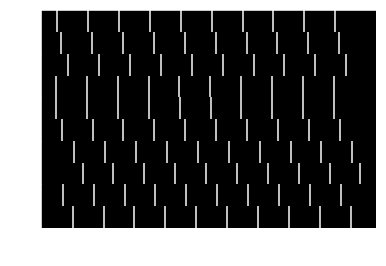

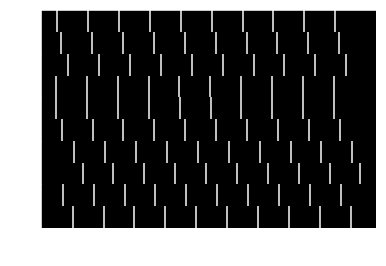

In [64]:
def raster(x_fire,inds):
        nn = len(inds)
        fig,ax = plt.subplots()
        for i in inds:
                for te in x_fire[i]:
                        ax.vlines(te,i,i+1,color='white')
        ax.set_ylim(0,nn)
        ax.set_xlabel('time in LFP cycle')
        ax.set_ylabel('neuron')
        xticks = np.arange(0,tf+2*np.pi,2*np.pi)
        ax.set_xticks(xticks)
        ax.set_xticklabels(map(str,range(len(xticks))))
        # fig.show()
        return fig
raster(x_fire,range(10))
# inds = range(10)
# N = len(inds)
# for i in inds:
#         for te in x_fire[i]:
#                 plt.vlines(te,i,i+1,color='white')
# plt.ylim(0,N)
# plt.xlabel('time in LFP phase')
# plt.ylabel('neuron')

(array([ 5., 11., 22., 20., 25., 26., 32., 35., 19.,  5.]),
 array([-0.54772679, -0.45211384, -0.35650088, -0.26088793, -0.16527498,
        -0.06966202,  0.02595093,  0.12156389,  0.21717684,  0.3127898 ,
         0.40840275]),
 <a list of 10 Patch objects>)

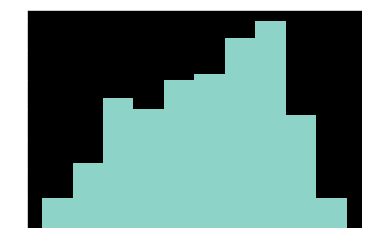

In [65]:
finalPhase = [ x_fire[i][-1] for i in range(N) ]
errors = np.array(finalPhase) - x_target
errors = np.mod(errors+np.pi,2*np.pi)-np.pi
plt.hist(errors)

In [66]:
np.save('x_fire_12112324_random_cue',x_fire)

In [67]:
np.save('x_target_12112324',x_target)

In [68]:
N = N	# number of neurons
M = 10	# number of memories
k_prior = 0.5	# von Mises concentration parameter
                # for prior distribution
k_noise = 10	# for cue distribution
x_memory = np.random.vonmises(0,k_prior,(N,M)) # every column 
                                        # is a memory trace
x_target = x_memory[:,0].copy()     # the first one is 
                                    # what we want to recall
x_0 = np.random.vonmises(0,k_prior,N) # random initial state
x_noise = np.random.vonmises(0,k_noise,N)   # indepedent random
                                # noise to corrupt the cue
x_tilde = x_target + x_noise 
W = np.zeros((N,N))
for i in range(N):
    for j in range(i): # j<i, Wii = 0
        for k in range(M): # the STDP rule is additive
            W[i,j] += omega(x_memory[i,k]-x_memory[j,k])
            W[j,i] += omega(x_memory[j,k]-x_memory[i,k])
W_flatten = [W[i][j] for i in range(N) for j in range(i) ]
sigma2_w = np.var(W_flatten)
# plt.hist(W_flatten,50)

# x_fire = [[ ] for j in range(N)] # record firing phase


In [69]:
print(not np.any(np.diag(W)))
i,j = np.random.randint(0,N,2)
print(W[i,j] + W[j,i] == 0)

True
True


In [70]:
for func in event: 
        func.terminal = False # continue integration when neuron fires
# first round
tf = 20*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until the end
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
x_fire = sol.t_events
print(sol.message)
print(tNow)
# print(len(xNow))

The solver successfully reached the end of the integration interval.
62.83185307179586


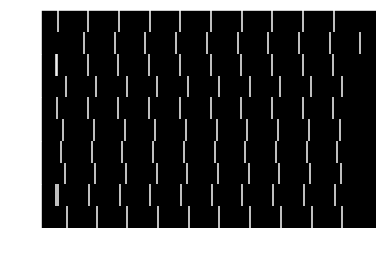

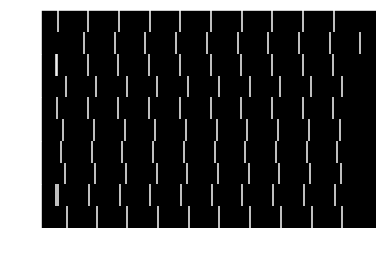

In [71]:
def raster(x_fire,inds):
        nn = len(inds)
        fig,ax = plt.subplots()
        for i in inds:
                for te in x_fire[i]:
                        ax.vlines(te,i,i+1,color='white')
        ax.set_ylim(0,nn)
        ax.set_xlabel('time in LFP cycle')
        ax.set_ylabel('neuron')
        xticks = np.arange(0,tf+2*np.pi,2*np.pi)
        ax.set_xticks(xticks)
        ax.set_xticklabels(map(str,range(len(xticks))))
        # fig.show()
        return fig
raster(x_fire,range(10))
# inds = range(10)
# N = len(inds)
# for i in inds:
#         for te in x_fire[i]:
#                 plt.vlines(te,i,i+1,color='white')
# plt.ylim(0,N)
# plt.xlabel('time in LFP phase')
# plt.ylabel('neuron')

Text(0,0.5,'counts')

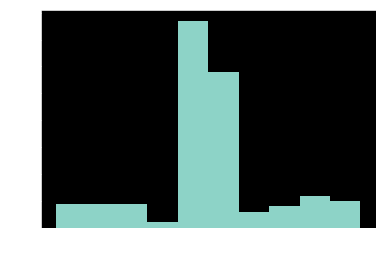

In [72]:
finalPhase = [ x_fire[i][-1] for i in range(N) ]
errors = np.array(finalPhase) - x_target
errors = np.mod(errors+np.pi,2*np.pi)-np.pi
plt.hist(errors)
plt.xlabel('errors')
plt.ylabel('counts')

Text(0,0.5,'counts')

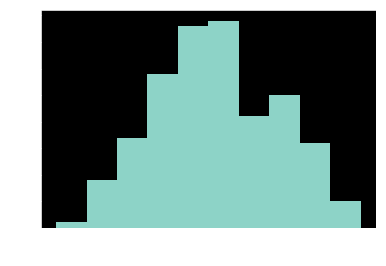

In [73]:
finalPhase = [ x_fire[i][-1] for i in range(N) ]
errors = np.array(finalPhase) - x_0
errors = np.mod(errors+np.pi,2*np.pi)-np.pi
plt.hist(errors)
plt.xlabel('errors')
plt.ylabel('counts')

Text(0,0.5,'counts')

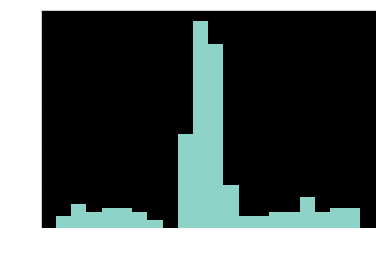

In [74]:
finalPhase = [ x_fire[i][-1] for i in range(N) ]
errors = np.array(finalPhase) - x_target
errors = np.mod(errors+np.pi,2*np.pi)-np.pi
plt.hist(errors,20)
plt.xlabel('errors')
plt.ylabel('counts')

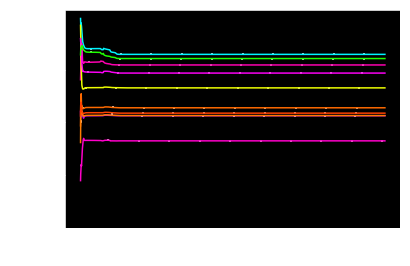

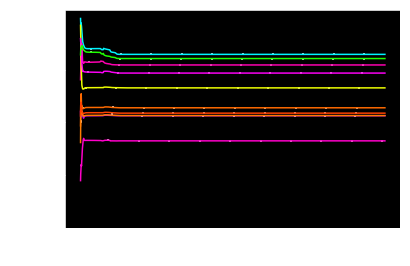

In [75]:
def fancyPlot(t,x,x_fire,x_target,inds):
        x_target[x_target<0]+=np.pi*2
        fig,ax = plt.subplots()
        for i in inds:
                timing = np.array(x_fire[i])
                phase = np.mod(timing+np.pi,2*np.pi)-np.pi
                color = cm.hsv(x_target[i]/(2*np.pi))
                ax.plot(t,x[i,:],c=color)
                for te,pe in zip(timing,phase):
                        ax.vlines(te,pe-0.03,pe+0.03,color='white')
        ax.set_xlabel('time in LFP cycle')
        xticks = np.arange(0,t[-1],2*np.pi)
        ax.set_xticks(xticks)
        ax.set_xticklabels(map(str,range(len(xticks))))
        ax.set_ylabel('instantaneous phase')
        ax.set_yticks(np.arange(-np.pi,np.pi,np.pi/2))
        # ax.set_ylabel([r'$-\pi$',r'$-\pi/2$','0',r'$\pi/2$'])
        return fig
fancyPlot(t,x,x_fire,x_target,range(10))

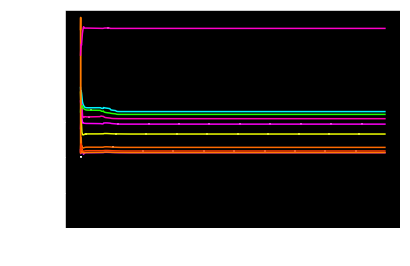

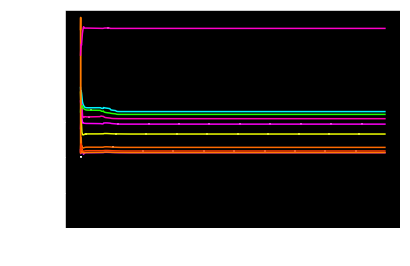

In [76]:
def fancyPlot(t,x,x_fire,x_target,inds):
        x_target = np.mod(x_target,np.pi*2)
        x = np.mod(x,np.pi*2)
        fig,ax = plt.subplots()
        for i in inds:
                timing = np.array(x_fire[i])
                phase = np.mod(timing,2*np.pi)
                color = cm.hsv(x_target[i]/(2*np.pi))
                ax.plot(t,x[i,:],c=color)
                for te,pe in zip(timing,phase):
                        ax.vlines(te,pe-0.03,pe+0.03,color='white')
        ax.set_xlabel('time in LFP cycle')
        xticks = np.arange(0,t[-1],2*np.pi)
        ax.set_xticks(xticks)
        ax.set_xticklabels(map(str,range(len(xticks))))
        ax.set_ylabel('instantaneous phase')
        ax.set_yticks(np.arange(-np.pi,np.pi,np.pi/2))
        # ax.set_ylabel([r'$-\pi$',r'$-\pi/2$','0',r'$\pi/2$'])
        return fig
fancyPlot(t,x,x_fire,x_target,range(10))

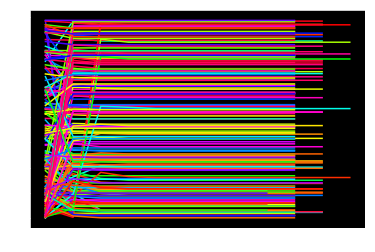

In [81]:
plt.rc('text', usetex=False)
for i in range(N):
        p = x_target[i]
        plt.plot(np.mod(x_fire[i],np.pi/2),c=cm.hsv(p/(2*np.pi)))


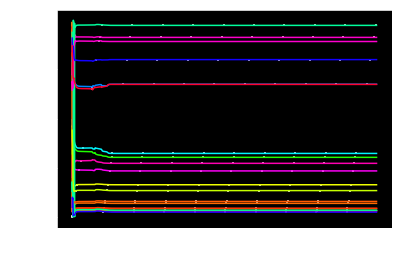

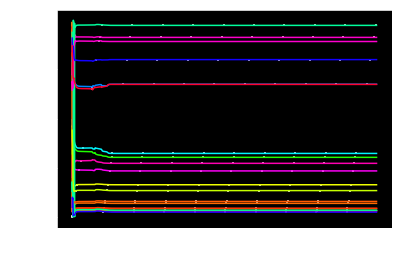

In [82]:
def fancyPlot(t,x,x_fire,x_target,inds):
        x_target = np.mod(x_target,np.pi*2)
        x = np.mod(x,np.pi*2)
        fig,ax = plt.subplots()
        for i in inds:
                timing = np.array(x_fire[i])
                phase = np.mod(timing,2*np.pi)
                color = cm.hsv(x_target[i]/(2*np.pi))
                ax.plot(t,x[i,:],c=color)
                for te,pe in zip(timing,phase):
                        ax.vlines(te,pe-0.03,pe+0.03,color='white')
        ax.set_xlabel('time in LFP cycle')
        xticks = np.arange(0,t[-1],2*np.pi)
        ax.set_xticks(xticks)
        ax.set_xticklabels(map(str,range(len(xticks))))
        ax.set_ylabel('instantaneous phase')
        ax.set_yticks(np.arange(0,np.pi*2,np.pi/2))
        ax.set_ylabel([r'0',r'pi/2',r'-pi',r'3\pi/2'])
        return fig
fancyPlot(t,x,x_fire,x_target,range(20))

In [83]:
np.save('x_12120034_full',x)
np.save('x_target_12120034_full',x_target)
np.save('x_fire_12120034_full',x_fire)
np.save('t_12120034_full',t)